# Build Data for Predictive Modeling

### Load Necessary Packages

In [1]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

### Create function for checking memory usage of dataframes

In [2]:
def check_memory_usage(data):
    """ Takes DataFrame as input and returns memory usage statistics.
    """
    print('')
    print('Checking memory usage statistics... ')
    print(data.info(memory_usage=True))

### Load the data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_data():
    """ Loads and returns competition data, including modified clients and products data.
    """
    # Defining Dataset


    # Load data efficiently to use less RAM
    train_types = {
                    'Semana': np.uint8, 'Agencia_ID': np.uint16, 'Canal_ID': np.uint8
                    ,'Ruta_SAK': np.uint16, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16
                    ,'Demanda_uni_equil': np.uint16
                    }

    test_types =  {
                    'Semana': np.uint8, 'Agencia_ID': np.uint16, 'Canal_ID': np.uint8
                    ,'Ruta_SAK': np.uint16, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16
                    }

    product_types = {'Producto_ID': np.uint16, 'weight': np.float32, 'pieces': np.float32
                    , 'weight_per_piece': np.float32, 'short_product_name': object
                    }

    #Loading data

    train = pd.read_csv('/content/drive/MyDrive/oo/Dataset/train.csv', sep = ",", usecols = train_types.keys(), dtype = train_types)
    test = pd.read_csv('/content/drive/MyDrive/oo/Dataset/test.csv', sep = ",", usecols = test_types.keys(), dtype = test_types)

    clients = pd.read_csv('/content/drive/MyDrive/oo/Dataset/cliente_tabla_modified.csv', sep = ",")
    products = pd.read_csv('/content/drive/MyDrive/oo/Dataset/producto_tabla_modified.csv', sep = ",", usecols = product_types.keys(), dtype = product_types)

    # Return data
    return train, test, clients, products

In [5]:
print("1. Loading data...")
train, test, clients, products = load_data()
print("Complete!")
print('')
check_memory_usage(train)

1. Loading data...
Complete!


Checking memory usage statistics... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Semana             uint8 
 1   Agencia_ID         uint16
 2   Canal_ID           uint8 
 3   Ruta_SAK           uint16
 4   Cliente_ID         uint32
 5   Producto_ID        uint16
 6   Demanda_uni_equil  uint16
dtypes: uint16(4), uint32(1), uint8(2)
memory usage: 990.4 MB
None


### Merge data

In [6]:
def merge_data(train, test, clients, products):
    """ Merges client and product data with train and test data.
        Returns modified train and test data.
    """

    # Merge product information
    train = train.merge(products, how = 'left', on = ['Producto_ID'])
    test = test.merge(products, how = 'left', on = ['Producto_ID'])

    # Merge cliente information
    train = train.merge(clients.loc[:, ['Cliente_ID', 'Client_Type']], how = 'left', on = ['Cliente_ID'])
    test = test.merge(clients.loc[:, ['Cliente_ID', 'Client_Type']], how = 'left', on = ['Cliente_ID'])

    return train, test

In [7]:
print("2. Merging data...")
train, test = merge_data(train, test, clients, products)
print("Complete!")
print("")
check_memory_usage(train)

2. Merging data...
Complete!


Checking memory usage statistics... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Semana              uint8  
 1   Agencia_ID          uint16 
 2   Canal_ID            uint8  
 3   Ruta_SAK            uint16 
 4   Cliente_ID          uint32 
 5   Producto_ID         uint16 
 6   Demanda_uni_equil   uint16 
 7   weight              float32
 8   pieces              float32
 9   weight_per_piece    float32
 10  short_product_name  object 
 11  Client_Type         object 
dtypes: float32(3), object(2), uint16(4), uint32(1), uint8(2)
memory usage: 2.9+ GB
None


### Add time series lag variables to data

In [8]:
def add_time_series_features(train, test):
    """ Takes train and test data as inputs.
        Adds lagged adjusted demand variables to the data periods t-2, t-3, t-4, and t-5.
        Returns modified data.
    """
    # Add lagged time series variables to train/test
    # Groups by (Cliente_ID, Producto_ID)
    for i in range(1, 6):
        # Add tminus to train
        columns = ['Semana', 'Cliente_ID', 'Producto_ID', 'Demanda_uni_equil']
        train_tminus = train.loc[:, columns]
        train_tminus = train_tminus.rename(columns = {'Demanda_uni_equil': 'Demanda_uni_equil_tminus' + str(i)})
        train_tminus['Semana'] = train_tminus['Semana'] + i
        columns.remove('Demanda_uni_equil')
        train_tminus = pd.DataFrame({'Demanda_uni_equil_tminus' + str(i) : train_tminus.groupby(columns)['Demanda_uni_equil_tminus' + str(i)].mean()}).reset_index()

        train = train.merge(train_tminus, how = 'left', on = ['Semana', 'Cliente_ID', 'Producto_ID'])
        train['Demanda_uni_equil_tminus' + str(i)] = train['Demanda_uni_equil_tminus' + str(i)].astype(np.float16)

        # Add tminus for Semana == 10
        columns = ['Semana', 'Cliente_ID', 'Producto_ID', 'Demanda_uni_equil_tminus' + str(i)]
        test = test.merge(train_tminus.loc[train_tminus['Semana'] == 10, columns], how = 'left', on = ['Semana', 'Cliente_ID', 'Producto_ID'])
        test['Demanda_uni_equil_tminus' + str(i)] = test['Demanda_uni_equil_tminus' + str(i)].astype(np.float16)

        # Add tminus for Semana == 11
        if(i != 1):
            test = test.merge(train_tminus.loc[train_tminus['Semana'] == 11, columns], how = 'left', on = ['Semana', 'Cliente_ID', 'Producto_ID'])
            test = test.rename(columns = {'Demanda_uni_equil_tminus' + str(i) + '_x': 'Demanda_uni_equil_tminus' + str(i)})
            test.loc[test['Semana'] == 11, 'Demanda_uni_equil_tminus' + str(i)] = test.loc[test['Semana'] == 11, 'Demanda_uni_equil_tminus' + str(i) + '_y']
            test = test.drop('Demanda_uni_equil_tminus' + str(i) + '_y', axis = 1)
            test['Demanda_uni_equil_tminus' + str(i)] = test['Demanda_uni_equil_tminus' + str(i)].astype(np.float16)

        # Replace null values with zeros
        train.loc[train['Demanda_uni_equil_tminus' + str(i)].isnull(), 'Demanda_uni_equil_tminus' + str(i)] = 0
        test.loc[test['Demanda_uni_equil_tminus' + str(i)].isnull(), 'Demanda_uni_equil_tminus' + str(i)] = 0

    return train, test

In [9]:
print("3. Adding time series features...")
train, test = add_time_series_features(train, test)
print("Complete!")
print("")
check_memory_usage(train)

3. Adding time series features...
Complete!


Checking memory usage statistics... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Semana                     uint8  
 1   Agencia_ID                 uint16 
 2   Canal_ID                   uint8  
 3   Ruta_SAK                   uint16 
 4   Cliente_ID                 uint32 
 5   Producto_ID                uint16 
 6   Demanda_uni_equil          uint16 
 7   weight                     float32
 8   pieces                     float32
 9   weight_per_piece           float32
 10  short_product_name         object 
 11  Client_Type                object 
 12  Demanda_uni_equil_tminus1  float16
 13  Demanda_uni_equil_tminus2  float16
 14  Demanda_uni_equil_tminus3  float16
 15  Demanda_uni_equil_tminus4  float16
 16  Demanda_uni_equil_tminus5  float16
dtypes: float16(5), float32(3), object(2),

### Add mean weekly frequency variables for categorical id variables

In [10]:
def add_mean_freq_by_id(train, test):
    """ Takes train and test data as inputs.
        Adds mean of frequencies of different id features by week (semana).
        Returns train and test data.
    """
    columns =  ['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'short_product_name', 'Client_Type']
    for column in columns:

        # Create mean of weekly id counts
        train_counts = pd.DataFrame({column + '_count' : train[[column, 'Semana']].groupby([column, 'Semana']).size()}).reset_index()
        test_counts = pd.DataFrame({column + '_count' : test[[column, 'Semana']].groupby([column, 'Semana']).size()}).reset_index()
        counts = pd.concat([train_counts, test_counts], axis = 0)
        counts = pd.DataFrame({column + '_count' : counts.groupby([column])[column + '_count'].mean()}).reset_index()
        counts[column + '_count'] = counts[column + '_count'].astype(np.float32)

        # Merge with train and test data
        train = train.merge(counts, how = 'left', on = column)
        test = test.merge(counts, how = 'left', on = column)

    return train, test

In [11]:
#print train.columns
print("4. Adding id frequency variables... ")
train, test = add_mean_freq_by_id(train, test)
print("Complete!")
print('')
check_memory_usage(train)

4. Adding id frequency variables... 
Complete!


Checking memory usage statistics... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74180464 entries, 0 to 74180463
Data columns (total 24 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Semana                     uint8  
 1   Agencia_ID                 uint16 
 2   Canal_ID                   uint8  
 3   Ruta_SAK                   uint16 
 4   Cliente_ID                 uint32 
 5   Producto_ID                uint16 
 6   Demanda_uni_equil          uint16 
 7   weight                     float32
 8   pieces                     float32
 9   weight_per_piece           float32
 10  short_product_name         object 
 11  Client_Type                object 
 12  Demanda_uni_equil_tminus1  float16
 13  Demanda_uni_equil_tminus2  float16
 14  Demanda_uni_equil_tminus3  float16
 15  Demanda_uni_equil_tminus4  float16
 16  Demanda_uni_equil_tminus5  float16
 17  Agencia_ID_count           float32

### Encode categorical variables

In [12]:
def encode_labels(train, test, threshold):
    """ Converts categorical features to integers in train and test data.
        Groups values in categorical features appearing less than threshold into a separate category.
        Returns train and test data.
    """

    # Identify columns for label encoding
    columns = list(train.columns[train.dtypes == 'object'])

    # Return data if no columns identified
    if(len(columns) == 0):
        return train, test

    # Transform columns
    for column in columns:

        # Filter data
        classes = train[column].unique()
        counts = train[column].value_counts()
        counts_classes = counts.index[counts <= threshold]

        # Set classes under threshold to 'identific'
        train.loc[train[column].isin(counts_classes), column] = 'identific'
        test.loc[test[column].isin(counts_classes), column] = 'identific'

        # Classes in test not in train sent to 'identific'
        test.loc[test[column].isin(classes) == False, column] = 'identific'

        # Perform label encoding
        le = LabelEncoder()
        le.fit(train[column])
        train[column] = le.transform(train[column]).astype(np.uint32)
        test[column] = le.transform(test[column]).astype(np.uint32)

    return train, test

In [13]:
print("5. Encoding labels in data...")
train, test = encode_labels(train, test, threshold = 5)
print("Complete!")

5. Encoding labels in data...
Complete!


### Remove data before Week 6

In [14]:
print("Shape Before (train): " + str(train.shape))
train = train[train['Semana'] > 5]
train = train.reset_index(drop=True)
print("Shape After (train): " + str(train.shape))

Shape Before (train): (74180464, 24)
Shape After (train): (41390267, 24)


### Reorder columns in data

In [15]:
columns = [
            'Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID'
            , 'Client_Type', 'short_product_name'
            , 'weight', 'pieces', 'weight_per_piece'
            , 'Demanda_uni_equil', 'Demanda_uni_equil_tminus1', 'Demanda_uni_equil_tminus2'
            , 'Demanda_uni_equil_tminus3', 'Demanda_uni_equil_tminus4', 'Demanda_uni_equil_tminus5'
            , 'Agencia_ID_count', 'Canal_ID_count', 'Ruta_SAK_count', 'Cliente_ID_count'
            , 'Producto_ID_count', 'Client_Type_count'
          ]

train = train.reindex(columns = columns)
columns.remove('Demanda_uni_equil')
test = test.reindex(columns = columns)

### Write data to CSV files

In [16]:
check_memory_usage(train)
train.to_csv("train_modified.csv", index = False, header = True)
test.to_csv("test_modified.csv", index = False, header = True)


Checking memory usage statistics... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41390267 entries, 0 to 41390266
Data columns (total 23 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Semana                     uint8  
 1   Agencia_ID                 uint16 
 2   Canal_ID                   uint8  
 3   Ruta_SAK                   uint16 
 4   Cliente_ID                 uint32 
 5   Producto_ID                uint16 
 6   Client_Type                uint32 
 7   short_product_name         uint32 
 8   weight                     float32
 9   pieces                     float32
 10  weight_per_piece           float32
 11  Demanda_uni_equil          uint16 
 12  Demanda_uni_equil_tminus1  float16
 13  Demanda_uni_equil_tminus2  float16
 14  Demanda_uni_equil_tminus3  float16
 15  Demanda_uni_equil_tminus4  float16
 16  Demanda_uni_equil_tminus5  float16
 17  Agencia_ID_count           float32
 18  Canal_ID_count             float32
 19  Ru

### Process complete!

# Modify Client and Product data

Client features inspired by: https://www.kaggle.com/abbysobh/grupo-bimbo-inventory-demand/classifying-client-type-using-client-names

Product features based on: https://www.kaggle.com/vykhand/grupo-bimbo-inventory-demand/exploring-products

### Import Necessary Packages

In [17]:
import os
import numpy as np
import pandas as pd
import re
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stemmer = SnowballStemmer('spanish')
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load the data

In [19]:
def load_data():
    """ Loads and returns client and product data.
    """
    # Set work directory
    # os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')

    # Load data
    clients = pd.read_csv('/content/drive/MyDrive/oo/Dataset/cliente_tabla.csv', sep = ",")
    products = pd.read_csv('/content/drive/MyDrive/oo/Dataset/producto_tabla.csv', sep = ",")

    # Return data
    return clients, products

In [20]:
print("1. Loading client and product data...")
clients, products = load_data()
print("Complete!")

1. Loading client and product data...
Complete!


### Build function to remove duplicate ids from client data

In [21]:
def remove_duplicate_ids(clients):
    """ Finds and removes duplicate ids from client data. Returns cleaned data.
    """
    duplicate_ids = clients.duplicated(subset = 'Cliente_ID')
    clients = clients[duplicate_ids == False]
    return clients

### Create Client_type feature

In [22]:
def create_client_features(clients):
    """ Takes clients data as input.
        Creates new variable 'Client_Type' by categorizing NombreCliente.
        Returns clients data.
    """

    # Remove duplicate ids
    clients = remove_duplicate_ids(clients)

    # Create new feature
    clients = clients.copy()
    clients['Client_Type'] = clients.loc[:, 'NombreCliente']

    # Convert to all UPPER-CASE
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.upper()

    # Known Large Company / Special Group Types
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*REMISION.*','Consignment')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*WAL MART.*','.*SAMS CLUB.*'],'Walmart', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*OXXO.*','Oxxo Store')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*CONASUPO.*','Govt Store')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*BIMBO.*','Bimbo Store')

    # Term search for assortment of words picked from looking at their frequencies
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*COLEG.*','.*UNIV.*','.*ESCU.*','.*INSTI.*',\
                                                        '.*PREPAR.*'],'School', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*PUESTO.*','Post')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*FARMA.*','.*HOSPITAL.*','.*CLINI.*'],'Hospital/Pharmacy', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*CAFE.*','.*CREMERIA.*','.*DULCERIA.*',\
                                                        '.*REST.*','.*BURGER.*','.*TACO.*', '.*TORTA.*',\
                                                        '.*TAQUER.*','.*HOT DOG.*',\
                                                        '.*COMEDOR.*', '.*ERIA.*','.*BURGU.*'],'Eatery', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].str.replace('.*SUPER.*','Supermarket')
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*COMERCIAL.*','.*BODEGA.*','.*DEPOSITO.*',\
                                                            '.*ABARROTES.*','.*MERCADO.*','.*CAMBIO.*',\
                                                        '.*MARKET.*','.*MART .*','.*MINI .*',\
                                                        '.*PLAZA.*','.*MISC.*','.*ELEVEN.*','.*EXP.*',\
                                                         '.*SNACK.*', '.*PAPELERIA.*', '.*CARNICERIA.*',\
                                                         '.*LOCAL.*','.*COMODIN.*','.*PROVIDENCIA.*'
                                                        ],'General Market/Mart'\
                                                       , regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*VERDU.*','.*FRUT.*'],'Fresh Market', regex=True)
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace(['.*HOTEL.*','.*MOTEL.*'],'Hotel', regex=True)

    # Filter participles
    clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].replace([
            '.*LA .*','.*EL .*','.*DE .*','.*LOS .*','.*DEL .*','.*Y .*', '.*SAN .*', '.*SANTA .*',\
            '.*AG .*','.*LAS .*','.*MI .*','.*MA .*', '.*II.*', '.*[0-9]+.*'\
                ],'Small Franchise', regex=True)

    # Everything else bucketed into 'Individual'
    def filter_remaining(clients):
        def function_word(data):
            # Avoid the single-words created so far by checking for upper-case
            if (data.isupper()) and (data != "NO IDENTIFICADO"):
                return 'Individual'
            else:
                return data
        clients.loc[:, 'Client_Type'] = clients.loc[:, 'Client_Type'].map(function_word)
    filter_remaining(clients)

    return clients

In [23]:
print("2. Generating new client features...")
clients = create_client_features(clients)
print("Complete!")
print(clients.head())

2. Generating new client features...
Complete!
   Cliente_ID                            NombreCliente      Client_Type
0           0                               SIN NOMBRE       Individual
1           1                         OXXO XINANTECATL       Individual
2           2                               SIN NOMBRE       Individual
3           3                                EL MORENO  Small Franchise
4           4  SDN SER  DE ALIM  CUERPO SA CIA  DE INT  Small Franchise


### Create new product features: short_product_name, brand, weight, weight_per_piece

In [24]:
def create_product_features(products):
    """ Takes products data as input and builds new features.
        Returns modified products data.
    """
    # Split NombreProducto and create new columns
    products['short_name'] = products['NombreProducto'].str.extract('^(\D*)', expand=False)
    products['brand'] = products['NombreProducto'].str.extract('^.+\s(\D+) \d+$', expand=False)
    w = products['NombreProducto'].str.extract('(\d+)(Kg|g)', expand=True)
    products['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
    products['pieces'] =  products['NombreProducto'].str.extract('(\d+)p ', expand=False).astype('float')
    products['weight_per_piece'] = products['weight'] / products['pieces']

    products['short_product_name'] = (products['short_name']
                                        .map(lambda x: " ".join([i for i in x.lower()
                                                                 .split() if i not in stopwords.words("spanish")])))


    products['short_product_name'] = (products['short_product_name']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))

    # Drop unnecessary variables
    products = products.drop(['NombreProducto', 'short_name'], axis = 1)

    return products

In [25]:
print("3. Generating new product features...")
products = create_product_features(products)
print("Complete!")
print(products.head())

3. Generating new product features...
Complete!
   Producto_ID         brand  weight  pieces  weight_per_piece  \
0            0  IDENTIFICADO     NaN     NaN               NaN   
1            9           NES   750.0     NaN               NaN   
2           41           BIM   480.0     6.0             80.00   
3           53           LON   170.0     NaN               NaN   
4           72            TR    45.0     4.0             11.25   

      short_product_name  
0              identific  
1           capuccin mok  
2  bimboll ext sajonjoli  
3           burrit sincr  
4   div tir mini doradit  


### Write modified dataframes to CSV files

In [26]:
print("4. Writing to CSV...")
clients.to_csv("cliente_tabla_modified.csv", index = False, header = True)
products.to_csv("producto_tabla_modified.csv", index = False, header = True)
print("Complete!")

4. Writing to CSV...
Complete!


### Process complete!

# Build Model and Generate Predictions

### Load Necessary Packages

In [27]:
import os
import time
import random

import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import re
import gc

### Create function for checking memory usage of dataframes

In [28]:
def check_memory_usage(data):
    """ Takes DataFrame as input and returns memory usage statistics.
    """
    print('')
    print('Checking memory usage statistics... ')
    print(data.info(memory_usage=True))

###  Create custom evaluation metric, Root Mean Log Squared Error (RMSLE)

In [29]:
def RMSLE(actuals, predictions):
    """ Takes true values and predictions. Returns their Root Mean Squared Logarithmic Error.
    """
    result = 0.0
    actuals = np.asarray(actuals) * 1.0
    predictions = np.asarray(predictions)
    if(len(actuals) == len(predictions)):
        result = np.sqrt(sum(((np.log(predictions + 1.0) - np.log(actuals + 1.0)) ** 2) / len(actuals)))
        return result
    else:
        return "Error!"

### Set seed for reproducibility purposes

In [30]:
random.seed(0)

### Load the data

In [31]:
def load_data():
    """ Loads and returns train and test data.
    """
    # Set work directory
#     os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')

    # Load data efficiently by setting numpy data types for variables
    train_types = {
         'Semana': np.uint8, 'Agencia_ID': np.uint16
         , 'Canal_ID': np.uint8
         , 'Ruta_SAK': np.uint16, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16
         , 'Client_Type': np.uint32
         , 'short_product_name': np.uint32, 'weight': np.float32, 'pieces': np.float32, 'weight_per_piece': np.float32
         , 'Demanda_uni_equil': np.float16
         , 'Demanda_uni_equil_tminus2': np.float16, 'Demanda_uni_equil_tminus3': np.float16
         , 'Demanda_uni_equil_tminus4': np.float16, 'Demanda_uni_equil_tminus5': np.float16
         , 'Agencia_ID_count': np.float32, 'Canal_ID_count': np.float32, 'Ruta_SAK_count': np.float32
         , 'Cliente_ID_count': np.float32, 'Producto_ID_count': np.float32, 'Client_Type_count': np.float32
         }

    test_types = {
         'Semana': np.uint8, 'Agencia_ID': np.uint16
         , 'Canal_ID': np.uint8
         , 'Ruta_SAK': np.uint16, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16
         , 'Client_Type': np.uint32
         , 'short_product_name': np.uint32, 'weight': np.float32, 'pieces': np.float32, 'weight_per_piece': np.float32
         , 'Demanda_uni_equil_tminus2': np.float16, 'Demanda_uni_equil_tminus3': np.float16
         , 'Demanda_uni_equil_tminus4': np.float16, 'Demanda_uni_equil_tminus5': np.float16
         , 'Agencia_ID_count': np.float32, 'Canal_ID_count': np.float32, 'Ruta_SAK_count': np.float32
         , 'Cliente_ID_count': np.float32, 'Producto_ID_count': np.float32, 'Client_Type_count': np.float32
         }

    train = pd.read_csv("./train_modified.csv", sep = ",", usecols = train_types.keys(), dtype = train_types)
    test = pd.read_csv("./test_modified.csv", sep = ",", usecols = test_types.keys(), dtype = test_types)

    return train, test

In [32]:
print("1. Loading data...")
train, test = load_data()
print("Complete!")
print('')
# check_memory_usage(train)

1. Loading data...
Complete!



### Prepare data for model fitting

In [33]:
def prepare_data(train, test, cv_index):
    """ Divide train data into training data for model and a hold-out validation set
        based on Semana value (can take 6, 7, 8, 9 as values).

        Splits outcome variable from data for model.

        Converts and returns dataframes as numpy matrices.
    """
    # Reset data indices
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)

    # Get CV indices from train (Semana == cv_index)
    cv_indices = train[train['Semana'] == cv_index].index
    train_indices = train[train['Semana'] != cv_index].index

    # Data for model building
    column_names = list(train.drop(['Demanda_uni_equil'], axis = 1).columns)
    y_train = train.loc[train_indices, 'Demanda_uni_equil'].values
    X_train = train.loc[train_indices, :].drop(['Demanda_uni_equil'], axis = 1).values
    y_validation = train.loc[cv_indices, 'Demanda_uni_equil'].values
    X_validation = train.loc[cv_indices, :].drop(['Demanda_uni_equil'], axis = 1).values

    # Return data
    return y_train, X_train, y_validation, X_validation, column_names

In [34]:
print("2. Preparing data for model building...")
cv_index = 9
y_train, X_train, y_validation, X_validation, column_names = prepare_data(train, test, cv_index)

# Remove original train data sets from memory
del train
gc.collect()

print("Complete!")

2. Preparing data for model building...
Complete!


### Define XGBOOST model and parameters

In [35]:
print("3. Create model and define parameters...")
xgb_params = {
             'objective': 'reg:linear'
             , 'n_estimators': 100
             , 'learning_rate': 0.26
             , 'max_depth': 12
             , 'seed': 0
             , 'booster': 'gbtree'
             }
model_xgb = xgb.XGBRegressor()
model_xgb.set_params(**xgb_params)

3. Create model and define parameters...


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.26, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Create function to plot XGBOOST learning curves during fitting process

In [36]:
def plot_learning_curves(model_xgb):
    """ Takes XGBOOST model fit on data.
        Plots train and validation RMSE for each iteration of model.
    """
    # Retrieve model performance metrics
    results = model_xgb.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # Plot RMSE
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE Performance')
    plt.show()

### Create function to display XGBOOST feature importance scores

In [37]:
def feature_importance_scores(model_xgb, column_names, cv_index, cv_score):
    """ Takes fit XGBOOST model, column names, validation set index, and validation RMSLE score as inputs.
        Plot and saves XGBOOST feature importance scores.
    """
    # Create dataframe of feature importance scores
    fscore = model_xgb.get_booster().get_fscore()
    feature_importances = []
    for ft, score in fscore.items():  # Use .items() instead of .iteritems()
        ft = column_names[int(re.sub("[^0-9]", "", ft))]
        feature_importances.append({'Feature': ft, 'Importance': score})
    feature_importances = pd.DataFrame(feature_importances)
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    feature_importances['Importance'] = feature_importances['Importance'] / feature_importances['Importance'].sum()

    feature_names = feature_importances['Feature']
    importances = feature_importances['Importance']
    y_pos = np.asarray(range(len(feature_names), 0, -1))

    # Plot scores
    plt.barh(y_pos, importances, align = 'center', alpha = 1.0)
    plt.yticks(y_pos, feature_names)
    plt.xlabel('Scores')
    plt.title('Feature Importance Scores')

    # Save to file
    # os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/schema')
    plt.savefig('feature_importances_xgb_' + '_' + 'Semana_' + str(cv_index) + '_' + 'cv_score_' + str(round(cv_score, 4)) + '_' + 'LB_score_' + '.png')
    # os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')

    # Display plot
    plt.show()

    return feature_importances

### Fit XGBOOST model to data

In [38]:
def fit_model_xgb(model, y_train, X_train, y_validation, X_validation, column_names):
    """ Takes XGBOOST model, all data sets excluding test, and data column names as inputs.
        Fits XGBOOST model on train data and checks RMSLE score on validation data.
    """
    # Start timer
    start = time.time()

    # Build predictive model
    print("Fitting predictive model...")
    model.fit(X_train, np.log1p(y_train)
            , eval_set = [(X_train, y_train), (X_validation, y_validation)]
            , eval_metric = "rmse"
            , early_stopping_rounds = 5)
    print("Model fitting complete!!!")

    # Generate and print CV RMSLE score: ....
    preds_validation = np.expm1(model.predict(X_validation))
    cv_score = RMSLE(y_validation, preds_validation)
    print("Validation Score (RMSLE): "+ str(round(cv_score, 4)))

    # Plot learning curves
    plot_learning_curves(model)
    print('')

    # Plot and save feature importance scores
    feature_importances = feature_importance_scores(model, column_names, cv_index, cv_score)
    print(feature_importances)
    print ('')

    # Calculate time elapsed
    end = time.time()
    time_elapsed = (end - start)

    # Print completion messages
    print("Model building complete!")
    print("Time Elapsed: " + str(time_elapsed) + " seconds")

    return model, cv_score, feature_importances, time_elapsed

4. Fitting data to model...
Fitting predictive model...


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:40:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:22.44208	validation_1-rmse:22.51869
[1]	validation_0-rmse:22.37514	validation_1-rmse:22.45266
[2]	validation_0-rmse:22.32557	validation_1-rmse:22.40397
[3]	validation_0-rmse:22.28865	validation_1-rmse:22.36784
[4]	validation_0-rmse:22.26119	validation_1-rmse:22.34074
[5]	validation_0-rmse:22.24082	validation_1-rmse:22.32099
[6]	validation_0-rmse:22.22546	validation_1-rmse:22.30602
[7]	validation_0-rmse:22.21404	validation_1-rmse:22.29502
[8]	validation_0-rmse:22.20531	validation_1-rmse:22.28675
[9]	validation_0-rmse:22.19868	validation_1-rmse:22.28054
[10]	validation_0-rmse:22.19364	validation_1-rmse:22.27590
[11]	validation_0-rmse:22.18957	validation_1-rmse:22.27209
[12]	validation_0-rmse:22.18651	validation_1-rmse:22.26933
[13]	validation_0-rmse:22.18409	validation_1-rmse:22.26723
[14]	validation_0-rmse:22.18233	validation_1-rmse:22.26574
[15]	validation_0-rmse:22.18096	validation_1-rmse:22.26454
[16]	validation_0-rmse:22.17967	validation_1-rmse:22.26340
[17]	va

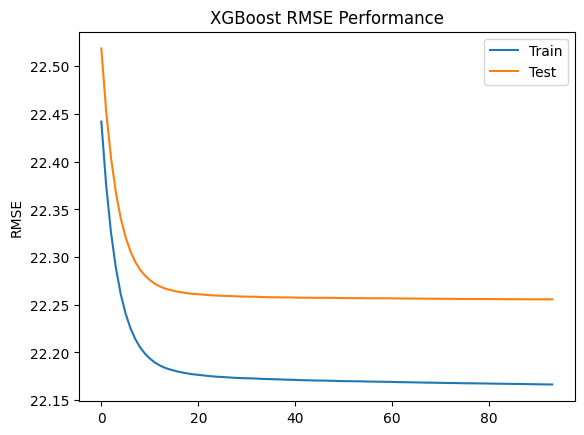

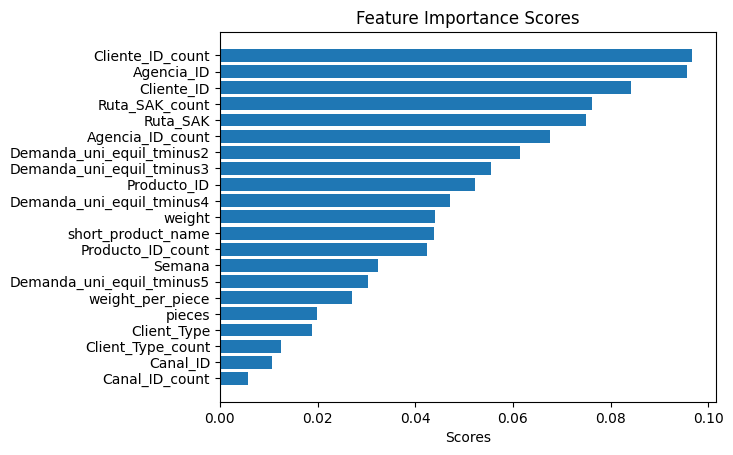

                      Feature  Importance
0            Cliente_ID_count    0.096735
1                  Agencia_ID    0.095680
2                  Cliente_ID    0.084257
3              Ruta_SAK_count    0.076201
4                    Ruta_SAK    0.075040
5            Agencia_ID_count    0.067628
6   Demanda_uni_equil_tminus2    0.061383
7   Demanda_uni_equil_tminus3    0.055593
8                 Producto_ID    0.052350
9   Demanda_uni_equil_tminus4    0.047232
10                     weight    0.044061
11         short_product_name    0.043759
12          Producto_ID_count    0.042325
13                     Semana    0.032417
14  Demanda_uni_equil_tminus5    0.030419
15           weight_per_piece    0.027140
16                     pieces    0.019868
17                Client_Type    0.018863
18          Client_Type_count    0.012512
19                   Canal_ID    0.010748
20             Canal_ID_count    0.005791

Model building complete!
Time Elapsed: 671.4620883464813 seconds
Complete!


In [39]:
print("4. Fitting data to model...")
model_xgb, cv_score, feature_importances, time_elapsed = fit_model_xgb(model_xgb, y_train, X_train, y_validation, X_validation, column_names)
print("Complete!")

### Generate predictions for test data

In [40]:
def generate_test_predictions(model, test):
    """ Takes fit XGBOOST model and test data as inputs.
        Generates and returns model predictions on test data.
    """
    predictions = np.expm1(model.predict(test.values))
    return predictions

In [41]:
print("5. Generating test set predictions...")
test_predictions = generate_test_predictions(model_xgb, test)
print("Complete!")

5. Generating test set predictions...
Complete!


### Write predictions to CSV

In [42]:
def generate_submission_CSV_predictions(predictions, cv_score, model_name, cv_index):
    """ Takes predictions, validation RMSLE score, string of model name, and index used for validation set as inputs.
        Writes test predictions to CSV file.
    """
    # Create dataframe with test predictions
    df = pd.DataFrame(predictions, dtype = float, columns = ['Demanda_uni_equil'])

    # Write to csv
    # os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/submissions')
    df.sort_values(by='Demanda_uni_equil', ascending=False, inplace=True)
    name = 'submission_' + model_name + '_' + 'Semana_' + str(cv_index) + '_' + 'cv_score_' + str(round(cv_score, 4)) + '_' + 'LB_score_' + '.csv'
    df.to_csv(name, index = True, header = True, index_label = 'id')
    # os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')

In [43]:
print("6. Writing predictions to CSV...")
generate_submission_CSV_predictions(test_predictions, cv_score, model_name = 'xgb', cv_index = cv_index)

6. Writing predictions to CSV...


### Process complete!

In [44]:
import pickle
model_filename = 'xgboost_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model_xgb, file)

In [45]:
with open(model_filename, 'rb') as file:
    model_pickle = pickle.load(file)

test_predictions_model = generate_test_predictions(model_pickle, test)
print("Complete!")
test_predictions_model

Complete!


array([3.855903 , 1.4700379, 2.0180395, ..., 2.550163 , 3.0261917,
       1.1600741], dtype=float32)

In [46]:
generate_submission_CSV_predictions(test_predictions_model, cv_score, model_name = 'xgb_pickle_loaded', cv_index = cv_index)